In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_csv("hf://datasets/criteo/FairJob/fairjob.csv.gz")
print(df.head())

   click  protected_attribute  senior  displayrandom  rank  user_id  \
0      0                    0       1              1     1    31020   
1      0                    0       1              0     3      515   
2      0                    1       1              0     1    12859   
3      0                    1       1              0     1    18781   
4      0                    0       1              0     9    19283   

   impression_id  product_id  cat0  cat1  ...     num41     num42     num43  \
0         175316       45953     6     6  ... -0.333033 -0.542801  0.074884   
1         129699       10569     8     8  ... -0.333033 -0.542801 -0.258659   
2         134573       51550     6     6  ... -0.333033 -0.542801 -0.236209   
3          84169       17843     3     3  ... -0.333033 -0.542801 -0.393358   
4          76506       11354     8     8  ... -0.333033 -0.542801  1.553377   

      num44     num45     num46     num47     num48     num49     num50  
0 -0.751637 -0.299223 -0

1. Data Overview

In [3]:
print("Basic Information:")
print(df.info())
print("\nShape of Data:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
null_counts = df.isnull().sum().sort_values(ascending=False)
print("\nNull Values Per Column (Descending Order):")
print(null_counts)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072226 entries, 0 to 1072225
Data columns (total 56 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   click                1072226 non-null  int64  
 1   protected_attribute  1072226 non-null  int64  
 2   senior               1072226 non-null  int64  
 3   displayrandom        1072226 non-null  int64  
 4   rank                 1072226 non-null  int64  
 5   user_id              1072226 non-null  int64  
 6   impression_id        1072226 non-null  int64  
 7   product_id           1072226 non-null  int64  
 8   cat0                 1072226 non-null  int64  
 9   cat1                 1072226 non-null  int64  
 10  cat2                 1072226 non-null  int64  
 11  cat3                 1072226 non-null  int64  
 12  cat4                 1072226 non-null  int64  
 13  cat5                 1072226 non-null  int64  
 14  cat6                 1072226 no

2. Data Cleaning (Outliers)

In [4]:
from scipy.stats import zscore
import numpy as np

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
def replace_outliers_with_mean(df, cols):
    for col in cols:
        mean_value = df[col].mean()
        std_value = df[col].std()
        z_scores = np.abs(zscore(df[col]))
        df.loc[z_scores > 3, col] = mean_value
replace_outliers_with_mean(df, num_cols)

3. Target Variable Analysis

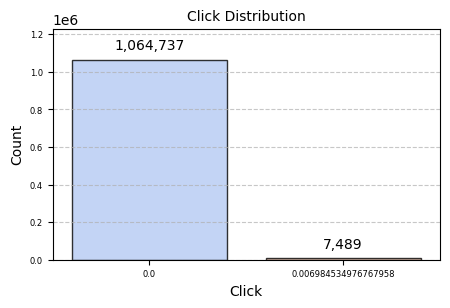

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = "coolwarm"

plt.figure(figsize=(5,3))
ax = sns.countplot(x='click', data=df, palette=palette, edgecolor="black", alpha=0.8)
plt.title("Click Distribution", fontsize=10)
plt.xlabel("Click", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

4. Protected Variable Analysis

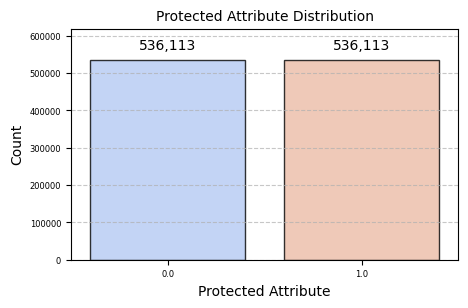

In [7]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='protected_attribute', data=df, palette=palette, edgecolor="black", alpha=0.8)
plt.title("Protected Attribute Distribution", fontsize=10)
plt.xlabel("Protected Attribute", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
click_rates = df.groupby('protected_attribute')['click'].mean()
print("Click rates by protected attribute:")
print(click_rates)

Click rates by protected attribute:
protected_attribute
0.0    0.000051
1.0    0.000047
Name: click, dtype: float64


5. Categorical Feature Analysis

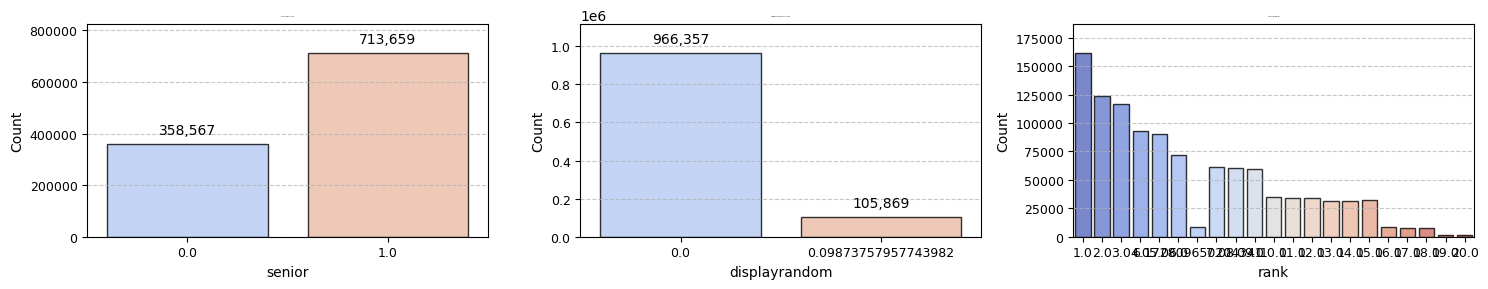

In [9]:
categorical_cols = ['senior', 'displayrandom', 'rank']
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(15, 3))
for i, col in enumerate(categorical_cols):
    ax = sns.countplot(x=col, data=df, ax=axes[i], palette=palette, edgecolor="black", alpha=0.8)
    axes[i].set_title(f"{col} Distribution", fontsize=1)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel("Count", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)
    ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
    if col != 'rank':
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

6. Bias Analysis

In [10]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['click'], df['protected_attribute'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test p-value: {p}")
if p < 0.05:
    print("Significant difference in click rates between protected attribute groups (Bias detected).")
else:
    print("No significant difference in click rates (No major bias detected).")

Chi-Square Test p-value: 0.0001298744839840157
Significant difference in click rates between protected attribute groups (Bias detected).


7. PCA Dimentionality Reduction

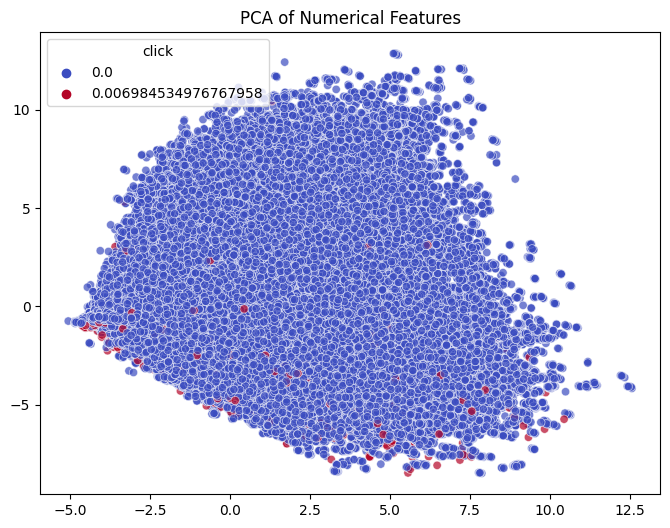

Explained Variance Ratio: [0.11781151 0.09947326]


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaled_features = scaler.fit_transform(df[numerical_cols].dropna())
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['click'], palette=palette, alpha=0.7)
plt.title("PCA of Numerical Features")
plt.show()
print("Explained Variance Ratio:", pca.explained_variance_ratio_)